In [1]:
# 从零实现一个具有张量的批量规范化层

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
b = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
print(b)
b.mean(dim=0)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


tensor([2.5000, 3.5000, 4.5000])

In [5]:
a = torch.arange(12, dtype=torch.float32).reshape(1, 2, 3, 2)
# len(a.shape)
print(a)
a.mean(dim=(0, 2, 3), keepdim=True)

tensor([[[[ 0.,  1.],
          [ 2.,  3.],
          [ 4.,  5.]],

         [[ 6.,  7.],
          [ 8.,  9.],
          [10., 11.]]]])


tensor([[[[2.5000]],

         [[8.5000]]]])

In [6]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0) # 行是样本，列是特征，计算所有样本的特征均值
            var = ((X - mean) ** 2).mean(dim=0)  # 计算所有样本的特征方差
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [7]:
class BatchNorm(nn.Module):
    # num_features: 完全连接层的输出数量或卷积层的输出通道数
    # num_dims: 2 表示完全连接层，4 表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean 和moving_var
        # 复制到显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean 和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

In [8]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),  # 28 - 5 + 1 =
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

In [15]:
x = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32).to('mps')
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__, 'output_shape:', x.shape)

Conv2d output_shape: torch.Size([1, 6, 24, 24])
BatchNorm output_shape: torch.Size([1, 6, 24, 24])
Sigmoid output_shape: torch.Size([1, 6, 24, 24])
AvgPool2d output_shape: torch.Size([1, 6, 12, 12])
Conv2d output_shape: torch.Size([1, 16, 8, 8])
BatchNorm output_shape: torch.Size([1, 16, 8, 8])
Sigmoid output_shape: torch.Size([1, 16, 8, 8])
AvgPool2d output_shape: torch.Size([1, 16, 4, 4])
Flatten output_shape: torch.Size([1, 256])
Linear output_shape: torch.Size([1, 120])
BatchNorm output_shape: torch.Size([1, 120])
Sigmoid output_shape: torch.Size([1, 120])
Linear output_shape: torch.Size([1, 84])
BatchNorm output_shape: torch.Size([1, 84])
Sigmoid output_shape: torch.Size([1, 84])
Linear output_shape: torch.Size([1, 10])


loss 0.220, train acc 0.918, test acc 0.861
8660.2 examples/sec on mps
time=2 m


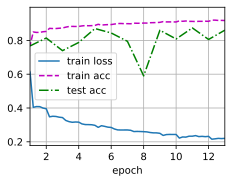

In [13]:
lr, num_epochs, batch_size = 1.0, 13, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
import time
start = time.time()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
tm = end - start
if 60<tm <3600:
    min = int(tm / 60)
    print(f'time={min} m')
else:
    hour = int(tm / 3600)
    min = int((tm - hour*3600)/60)
    print(f'time={hour} h, {min} m')

In [26]:
# 使用高级api
net2 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),  # 28 - 5 + 1 =
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120),
    #nn.BatchNorm1d(120),
    nn.Dropout(0.3),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    #nn.BatchNorm1d(84),
    nn.Dropout(0.3),
    nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.256, train acc 0.905, test acc 0.799
19060.6 examples/sec on mps
time=74.335


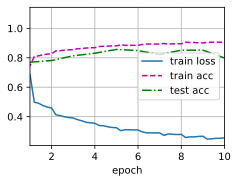

In [23]:
start = time.time()
num_epochs = 10
d2l.train_ch6(net2, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
tm = end - start
print(f"time={tm:.3f}")

loss 0.352, train acc 0.871, test acc 0.840
20310.3 examples/sec on mps
time=72.612


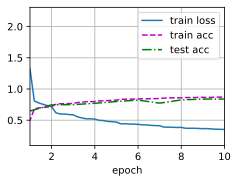

In [25]:
# 全连接层不使用规范化
start = time.time()
num_epochs = 10
d2l.train_ch6(net2, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
tm = end - start
print(f"time={tm:.3f} s")

loss 0.429, train acc 0.845, test acc 0.846
17942.5 examples/sec on mps
time=76.948 s


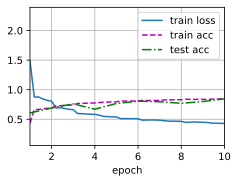

In [27]:
## 全连阶层使用Dropout
start = time.time()
num_epochs = 10
d2l.train_ch6(net2, train_iter, test_iter, num_epochs, lr, 'mps')
end = time.time()
tm = end - start
print(f"time={tm:.3f} s")

<generator object Module.parameters at 0x7f888da6ceb0>